In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
from dateutil.parser import parse
pd.set_option("display.max_rows", 15)
pd.set_option("display.max_columns", 30)
import datetime
from dateutil.parser import parse
import math

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import ipynbname
nb_fname = ipynbname.name()

### Research Context and Goal
The goal of the modelling at hand is to predict toxicity test values for the toxin type DSP in seashell based on the abundance of micro-algae in combination with available environmental data. Marine biologists are also interested to understand which species of micro-algae affects the accumulation of toxins in the seashells. 

The monitoring of abundance of micro-algae is carried out by the National Institute of Biology, Marine Biological Station Piran. The toxicity tests are performed by the National Veterinary Institute, Faculty of Veterinary Medicine (UL), which depending on the results of these tests administers bans on sales of shellfish. 

# Data preprocessing

## 1. Micro-algae dataset

In [2]:
# Create micro-algae dataframe (empty cells -> NaN)
df_alg = pd.read_csv("data/Algae_Podatki_1994_onwards_02112022_Martin_1_0.csv", na_values = ["NA", "?"], sep=";")

# Keep only columns: DSP,  Dinophysis species of special interest,  DSP_like,
df_alg = df_alg[["date", "sampling station", "sampling depth", "sampling method", "DSP", 
                 "DSP_like", "Dinophysis caudata", "Dinophysis fortii", "Phalacroma rotundatum", 
                 "Dinophysis sacculus", "Dinophysis tripos"]]
#replace , with .
df_alg.replace(",", ".", regex=True, inplace=True)

# create timestamp (Option to use parameter dayfirst=True, but seems unreliable)
df_alg["date"] = pd.to_datetime(df_alg["date"])

# sort by date attribute
df_alg = df_alg.sort_values('date')

# change str numbers to floats
df_alg.loc[:,"DSP":"Dinophysis tripos"] = df_alg.loc[:,"DSP":"Dinophysis tripos"].astype(float)

# Standardise station names
df_alg["sampling station"].replace("0035", 35, inplace=True)
df_alg["sampling station"].replace("0024", 24, inplace=True)

# Change station names to str
df_alg["sampling station"] = df_alg["sampling station"].astype(str)

df_alg

,date,sampling station,sampling depth,sampling method,DSP,DSP_like,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos
0,1994-05-17,35,0,Niskin,68.0,NaN,27.0,0.0,21.0,0.0,0.0
1,1994-05-17,35,12,Niskin,16.0,NaN,13.0,0.0,3.0,0.0,0.0
2,1994-05-17,35,5,Niskin,41.0,NaN,38.0,0.0,3.0,0.0,0.0
3,1994-05-17,24,0,Niskin,17.0,NaN,8.0,0.0,0.0,0.0,0.0
4,1994-05-17,24,12,Niskin,2.0,NaN,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1646,2021-11-30,24,integrated,hose sampler,120.0,0.0,40.0,40.0,20.0,10.0,0.0
1648,2021-11-30,0DB2,integrated,hose sampler,50.0,10.0,0.0,30.0,20.0,0.0,0.0
1650,2021-12-14,35,integrated,hose sampler,10.0,0.0,0.0,0.0,10.0,0.0,0.0
1649,2021-12-14,24,integrated,hose sampler,60.0,0.0,0.0,20.0,30.0,0.0,0.0


In [3]:
# Rescale values of samples with sampling method type "integrated phytoplankton net" by factor
phyto_net_factor = 100
idxs_net = df_alg[df_alg["sampling method"] == "phytoplankton net"].index
df_alg.loc[idxs_net, "DSP":"Dinophysis tripos"] = df_alg.loc[idxs_net, "DSP":"Dinophysis tripos"]*phyto_net_factor

In [4]:
# Resolve multiple samples from the same day and location with different sampling depth by keeping only 
# those with the highest abundace value of priority microalgae type (DSP).
df_alg_depth = df_alg.copy()
df_alg_depth["org_index"] = df_alg_depth.index
df_max_DSP = df_alg_depth.groupby(["date", "sampling station"], 
                                  as_index=False).agg({"DSP": lambda x: np.argmax(x), "org_index": lambda x: tuple(x)})
# df_max_DSP

# Use max value index of tuple consisting of original indexes to find the maxid (for DSP) of original dataset
maxid_list = []
for df_idx, group_idxs in df_max_DSP.org_index.iteritems():
    tuple_idx = df_max_DSP.loc[df_idx, "DSP"]
    maxid_list.append(group_idxs[tuple_idx]) 

df_alg = df_alg.iloc[maxid_list]

In [5]:
# Count of missing values
df_alg.isnull().sum()

date                      0
sampling station          0
sampling depth            0
sampling method           0
DSP                       1
DSP_like                 60
Dinophysis caudata        1
Dinophysis fortii         1
Phalacroma rotundatum     1
Dinophysis sacculus       1
Dinophysis tripos         1
dtype: int64

In [6]:
# Create pickle
df_alg.to_pickle(f"objects/df_alg-{nb_fname}")

## 2. Toxins dataset

In [7]:
# Create toxins dataframe
# empty cells [test not available, not in the program of testing] -> NaN
df_tox = pd.read_csv("data/Toxins_Podatki_1994_onwards_02112022_Martin_1_0.csv", 
                     na_values=["x", "? (no data)", "unreliable", 
                                "niso več delali analiz, ker nimajo školjk konzumne velikosti"], sep=";")  
df_tox = df_tox.drop(columns=["data source", "PSP toxins", "ASP toxins", "yessotoxins", "comments"])

# # create timestamp
df_tox["date"] = pd.to_datetime(df_tox["date"], infer_datetime_format=True)

# # sort by date attribute
df_tox = df_tox.sort_values('date')

# # set DateTime as index
df_tox.set_index('date', inplace=True)

# df_tox

In [8]:
# Adjustments to the dataset values ["< MD", "< 3 mg DA/kg", "< 0,2 mg DA/kg", 
# "0,2 mg DA/kg (neg)", "0.29 mg/kg", "neg (na meji)"] -> neg
df_tox.replace(to_replace=["< MD", "< 3 mg DA/kg", "< 0,2 mg DA/kg", "0,2 mg DA/kg (neg)", 
                           "0.29 mg/kg", "neg (na meji)"], value="neg", inplace=True)
# ">320, ocena 920" -> 920 [estimated value], 
df_tox.replace(">320, ocena 920", 920, inplace=True)
#>320, ocena 1580" -> 1580
df_tox.replace(">320, ocena 1580", 1580, inplace=True)
#">320, ocena 1880" -> 1880
df_tox.replace(">320, ocena 1880", 1880, inplace=True)
#">320, ocena 336" -> 336
df_tox.replace(">320, ocena 336", 336, inplace=True)
# ">320, ocena 470" -> 470, 
df_tox.replace(">320, ocena 470", 470, inplace=True)
#">240, ocena 510" -> 510, 
df_tox.replace(">240, ocena 510", 510, inplace=True)
#">240" -> 240, 
df_tox.replace(">240", 240, inplace=True)

# at index 947: yessotoxins="0.29 mg/kg" [need to convert to poz / neg); 
# Or should we ignore yesstoxins since only one 4 values?

In [9]:
# Standardise station names
df_tox["sampling station"].replace("0035", 35, inplace=True)
df_tox["sampling station"].replace("0024", 24, inplace=True)

# Change station names to str
df_tox["sampling station"] = df_tox["sampling station"].astype(str)

In [10]:
# Mapping num values -> "poz" or "neg" based on treshold (173 µg/kg = legal limit concentration for DSP toxins, 
# that induce shellfish harvesting ban)
numbers = [str(x) for x in range(10)]
for idx, value in df_tox["lipophylic toxins (OA (µg/kg))"].iteritems():
    if any(x in str(value) for x in numbers):
        if int(value) >= 173:
            #print(f"old value: {value}")
            value = "poz"
            #print(f"new value: {value}")
            df_tox["lipophylic toxins (OA (µg/kg))"][idx] = value
        else:
            #print(f"old value: {value}")
            value = "neg"
            #print(f"new value: {value}")
            df_tox["lipophylic toxins (OA (µg/kg))"][idx] = value

In [11]:
# Joining lipophylic toxins into one column.
# Just copying values from "lipophylic toxins (OA (µg/kg))"[930:] to "lipophylic toxins" and 
# keep the latter as "lipophylic toxins (DTX2 (µg/kg))" has no positive values.
df_tox["lipophylic toxins"][930:] = df_tox["lipophylic toxins (OA (µg/kg))"][930:]

# Remove columns "lipophylic toxins (OA (µg/kg))" and "lipophylic toxins (DTX2 (µg/kg))" from dataframe
df_tox.drop(columns=["lipophylic toxins (OA (µg/kg))", "lipophylic toxins (DTX2 (µg/kg))"], inplace=True)
print(f"lipophylic toxins classes:") 
df_tox["lipophylic toxins"].value_counts(dropna=False)



lipophylic toxins classes:


neg    1230
poz     172
NaN     159
Name: lipophylic toxins, dtype: int64

In [12]:
# Print out toxins dataset
pd.set_option('display.max_rows', 15)
df_tox

,sampling station,lipophylic toxins,ban start,ban stop
date,,,,
1989-09-15,35,poz,NaN,NaN
1989-09-15,24,poz,NaN,NaN
1989-09-25,35,NaN,y,NaN
1989-09-25,24,NaN,y,NaN
1989-09-25,0DB2,poz,y,NaN
...,...,...,...,...
2021-12-07,35,neg,NaN,NaN
2021-12-07,0DB2,neg,NaN,NaN
2021-12-15,35,neg,NaN,NaN


In [13]:
# Descriptive statistics of toxins dataset
df_tox.describe()

,sampling station,lipophylic toxins,ban start,ban stop
count,1561,1402,83,83
unique,3,2,1,1
top,24,neg,y,y
freq,578,1230,83,83


# 3. Consolidating datasets 

In order to learn a model that can make predictions about the toxicity tests' results from the algae abundance we need to alocate to the algae abundace instances a matching toxicity test, while the datasets have different temporal resolution and frequency of sampling. We will do this separately for each of the three locations.

Divide algae dataset by locations 35, 24 and 0DB2.

In [14]:
# df_alg for station 35
df_alg_35 = df_alg[df_alg["sampling station"] == "35"].copy()
# df for station 24
df_alg_24 = df_alg[df_alg["sampling station"] == "24"].copy()
# df for station 0DB2
df_alg_0DB2 = df_alg[df_alg["sampling station"] == "0DB2"].copy()

Divide toxin dataset by locations 35, 24 and 0DB2.

In [15]:
df_alg_35

,date,sampling station,sampling depth,sampling method,DSP,DSP_like,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos
0,1994-05-17,35,0,Niskin,68.0,NaN,27.0,0.0,21.0,0.0,0.0
8,1994-06-21,35,0,bucket,20.0,NaN,8.0,0.0,0.0,0.0,0.0
11,1994-07-14,35,0,bucket,26.0,NaN,2.0,2.0,20.0,2.0,0.0
14,1994-08-24,35,0,bucket,10.0,NaN,0.0,5.0,5.0,0.0,0.0
18,1994-11-22,35,0,bucket,2.0,NaN,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1638,2021-10-14,35,integrated,hose sampler,120.0,10.0,0.0,70.0,40.0,10.0,0.0
1641,2021-11-02,35,integrated,hose sampler,180.0,0.0,0.0,130.0,20.0,0.0,0.0
1644,2021-11-17,35,integrated,hose sampler,30.0,0.0,0.0,20.0,10.0,0.0,0.0
1647,2021-11-30,35,integrated,hose sampler,140.0,0.0,10.0,60.0,40.0,0.0,0.0


In [16]:
# df_tox for station 35
df_tox_35 = df_tox[df_tox["sampling station"] == "35"].copy()
# df_tox for station 24
df_tox_24 = df_tox[df_tox["sampling station"] == "24"].copy()
# df_tox for station 0DB2
df_tox_0DB2 = df_tox[df_tox["sampling station"] == "0DB2"].copy()

In [17]:
df_tox_35

,sampling station,lipophylic toxins,ban start,ban stop
date,,,,
1989-09-15,35,poz,NaN,NaN
1989-09-25,35,NaN,y,NaN
1989-12-10,35,NaN,NaN,y
1990-07-25,35,poz,y,NaN
1990-08-02,35,neg,NaN,y
...,...,...,...,...
2021-11-12,35,neg,NaN,NaN
2021-11-25,35,neg,NaN,NaN
2021-11-30,35,poz,NaN,NaN


Prepare new dataframes for consolidated datasets by locations 35, 24 and 0DB2.

In [18]:
# df_cons for station 35
df_cons_35 = df_alg_35.copy()
df_cons_35["lipophylic_toxins"] = np.nan

# df_cons for station 24
df_cons_24 = df_alg_24.copy()
df_cons_24["lipophylic_toxins"] = np.nan

# df_cons for station 0DB2 
df_cons_0DB2 = df_alg_0DB2.copy()
df_cons_0DB2["lipophylic_toxins"] = np.nan

### 3.1 Consolidation of abundance and toxin data

In [19]:
# # Loop to add appropriate toxin test results to algae samples; add first toxin test 
# # after timestamp of an algae sample but no older tests then 30 days.
# max_range = pd.Timedelta(30, unit="day")
# min_range = pd.Timedelta(0, unit="day")

# df_cons_list = [df_cons_35, df_cons_24, df_cons_0DB2]
# df_tox_list = [df_tox_35, df_tox_24, df_tox_0DB2]


# for _ in range(3):           
#     matches = 0
#     # Iterate over consolidated df and select a date of the algae sample
#     for id_alg, date_alg in df_cons_list[_]["date"].iteritems():
#         # Iterate over toxin df and select the date of test 
#         tox_list = []
#         for date_tox in df_tox_list[_]["lipophylic toxins"].index:
#             # Calculate the timespan between algae sample and toxin test 
#             timespan = date_tox - date_alg
#             # If timespan within 30 days
#             if min_range <= timespan <= max_range:
#                 # The toxin result on first acceptable toxin test day (date_tox) 
#                 tox_result = df_tox_list[_].loc[date_tox, "lipophylic toxins"]
#                 # Use only non-NaN tox_result (neg/pos)
#                 if type(tox_result) == pd.Series:
#                     print("Warning: duplicated dates", tox_result)
#                     continue
#                 if tox_result != np.NaN:
#                     tox_list.append((tox_result, timespan))
#                     # We list matching results but take the closest one.
#         tox_list.sort(key= lambda x: x[1])
#         if len(tox_list) > 0:
#             # print(tox_list)
#             df_cons_list[_].loc[id_alg, "lipophylic_toxins"] = tox_list[0][0]
#             matches += 1
            
#     print(f"Found matching test dates for {_}: {matches}")

In [20]:
# ==== Adding time deltas! ======
# Loop to add appropriate toxin test results to algae samples; add first toxin test 
# after timestamp of an algae sample but no older tests then 30 days.
max_range = pd.Timedelta(30, unit="day")
min_range = pd.Timedelta(0, unit="day")

df_cons_list = [df_cons_35, df_cons_24, df_cons_0DB2]
df_tox_list = [df_tox_35, df_tox_24, df_tox_0DB2]

for _ in range(3):
    matches = 0
    # Adding a new column for storing time deltas
    df_cons_list[_]["lipophylic_toxins_timedelta"] = pd.NaT
    
    # Iterate over consolidated df and select a date of the algae sample
    for id_alg, date_alg in df_cons_list[_]["date"].iteritems():
        # Iterate over toxin df and select the date of test 
        tox_list = []
        for date_tox in df_tox_list[_]["lipophylic toxins"].index:
            # Calculate the timespan between algae sample and toxin test 
            timespan = date_tox - date_alg
            # If timespan within 30 days
            if min_range <= timespan <= max_range:
                # The toxin result on first acceptable toxin test day (date_tox) 
                tox_result = df_tox_list[_].loc[date_tox, "lipophylic toxins"]
                # Use only non-NaN tox_result (neg/pos)
                if type(tox_result) == pd.Series:
                    print("Warning: duplicated dates", tox_result)
                    continue
                if tox_result != np.NaN:
                    tox_list.append((tox_result, timespan))
                    # We list matching results but take the closest one.
        tox_list.sort(key= lambda x: x[1])
        if len(tox_list) > 0:
            # print(tox_list)
            df_cons_list[_].loc[id_alg, "lipophylic_toxins"] = tox_list[0][0]
            # Adding the time delta to the new column
            df_cons_list[_].loc[id_alg, "lipophylic_toxins_timedelta"] = tox_list[0][1]
            matches += 1
            
    print(f"Found matching test dates for {_}: {matches}")

2020-03-09    neg
2020-03-09    neg
Name: lipophylic toxins, dtype: object
2020-03-09    neg
2020-03-09    neg
Name: lipophylic toxins, dtype: object
Found matching test dates for 0: 445
2004-10-05    neg
2004-10-05    poz
Name: lipophylic toxins, dtype: object
2004-10-05    neg
2004-10-05    poz
Name: lipophylic toxins, dtype: object
2004-10-05    neg
2004-10-05    poz
Name: lipophylic toxins, dtype: object
2004-10-05    neg
2004-10-05    poz
Name: lipophylic toxins, dtype: object
2010-08-17    poz
2010-08-17    neg
Name: lipophylic toxins, dtype: object
2010-08-17    poz
2010-08-17    neg
Name: lipophylic toxins, dtype: object
2010-08-17    poz
2010-08-17    neg
Name: lipophylic toxins, dtype: object
2010-08-17    poz
2010-08-17    neg
Name: lipophylic toxins, dtype: object
2020-03-09    neg
2020-03-09    neg
Name: lipophylic toxins, dtype: object
2020-03-09    neg
2020-03-09    neg
Name: lipophylic toxins, dtype: object
Found matching test dates for 1: 441
2020-03-09    neg
2020-03-

#### Consolidate datasets from each location

In [41]:
# Concatenated dataframe from each location to get final consolidated dataset
df_cons = pd.concat([df_cons_35, df_cons_24, df_cons_0DB2])

# sort by date attribute
df_cons = df_cons.sort_values('date')

pd.set_option('display.max_rows', 10)  # Adjust the number of rows as needed

df_cons

,date,sampling station,sampling depth,sampling method,DSP,DSP_like,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,lipophylic_toxins,lipophylic_toxins_timedelta
0,1994-05-17,35,0,Niskin,68.0,NaN,27.0,0.0,21.0,0.0,0.0,NaN,NaN
3,1994-05-17,24,0,Niskin,17.0,NaN,8.0,0.0,0.0,0.0,0.0,NaN,NaN
6,1994-06-06,0DB2,0,bucket,27.0,NaN,16.0,3.0,5.0,0.0,0.0,NaN,NaN
7,1994-06-13,24,0,bucket,23.0,NaN,3.0,0.0,0.0,0.0,0.0,NaN,NaN
8,1994-06-21,35,0,bucket,20.0,NaN,8.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,2021-11-30,35,integrated,hose sampler,140.0,0.0,10.0,60.0,40.0,0.0,0.0,poz,0 days 00:00:00
1648,2021-11-30,0DB2,integrated,hose sampler,50.0,10.0,0.0,30.0,20.0,0.0,0.0,poz,0 days 00:00:00
1650,2021-12-14,35,integrated,hose sampler,10.0,0.0,0.0,0.0,10.0,0.0,0.0,neg,1 days 00:00:00
1649,2021-12-14,24,integrated,hose sampler,60.0,0.0,0.0,20.0,30.0,0.0,0.0,neg,1 days 00:00:00


In [48]:
# Filter the dataframes based on 'sampling station'
df_cons_35 = df_cons[df_cons['sampling station'] == "35"].copy()
df_cons_24 = df_cons[df_cons['sampling station'] == "24"].copy()
df_cons_0DB2 = df_cons[df_cons['sampling station'] == "0DB2"].copy()

# Calculate the time deltas for each filtered dataframe
df_cons_35['time_delta'] = df_cons_35['date'].diff()
df_cons_24['time_delta'] = df_cons_24['date'].diff() 
df_cons_0DB2['time_delta'] = df_cons_0DB2['date'].diff() 

# Concatenate the filtered dataframes back into a single dataframe
df_cons_td = pd.concat([df_cons_35, df_cons_24, df_cons_0DB2])

# Sort the combined dataframe by date if needed
df_cons_td = df_cons_td.sort_values('date')
df_cons_td

,date,sampling station,sampling depth,sampling method,DSP,DSP_like,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,lipophylic_toxins,lipophylic_toxins_timedelta,time_delta
0,1994-05-17,35,0,Niskin,68.0,NaN,27.0,0.0,21.0,0.0,0.0,NaN,NaN,NaT
3,1994-05-17,24,0,Niskin,17.0,NaN,8.0,0.0,0.0,0.0,0.0,NaN,NaN,NaT
6,1994-06-06,0DB2,0,bucket,27.0,NaN,16.0,3.0,5.0,0.0,0.0,NaN,NaN,NaT
7,1994-06-13,24,0,bucket,23.0,NaN,3.0,0.0,0.0,0.0,0.0,NaN,NaN,27 days
8,1994-06-21,35,0,bucket,20.0,NaN,8.0,0.0,0.0,0.0,0.0,NaN,NaN,35 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,2021-11-30,35,integrated,hose sampler,140.0,0.0,10.0,60.0,40.0,0.0,0.0,poz,0 days 00:00:00,13 days
1648,2021-11-30,0DB2,integrated,hose sampler,50.0,10.0,0.0,30.0,20.0,0.0,0.0,poz,0 days 00:00:00,13 days
1650,2021-12-14,35,integrated,hose sampler,10.0,0.0,0.0,0.0,10.0,0.0,0.0,neg,1 days 00:00:00,14 days
1649,2021-12-14,24,integrated,hose sampler,60.0,0.0,0.0,20.0,30.0,0.0,0.0,neg,1 days 00:00:00,14 days


In [52]:
pd.set_option('display.max_rows', 100)  
df_cons_td.time_delta.value_counts()

14 days      227
13 days      148
7 days       147
15 days      145
8 days        77
9 days        71
12 days       64
6 days        52
28 days       50
19 days       43
16 days       42
27 days       35
23 days       30
10 days       24
20 days       23
17 days       23
11 days       22
29 days       22
21 days       20
30 days       20
22 days       15
18 days       15
35 days       14
33 days       14
36 days        9
24 days        8
40 days        8
34 days        7
26 days        7
5 days         7
0 days         5
31 days        4
148 days       4
64 days        3
200 days       3
161 days       3
53 days        3
49 days        3
39 days        3
173 days       2
37 days        2
58 days        2
3 days         2
153 days       2
191 days       2
225 days       2
25 days        1
63 days        1
76 days        1
3824 days      1
90 days        1
211 days       1
60 days        1
61 days        1
32 days        1
41 days        1
206 days       1
230 days       1
55 days       

In [53]:
df_cons_td.time_delta.describe()

count                           1449
mean      20 days 20:11:25.714285714
std      102 days 09:02:54.229472484
min                  0 days 00:00:00
25%                 10 days 00:00:00
50%                 14 days 00:00:00
75%                 19 days 00:00:00
max               3824 days 00:00:00
Name: time_delta, dtype: object

In [67]:
df_cons["lipophylic_toxins_timedelta"].describe()

count                         1222
mean     6 days 11:21:06.775777414
std      7 days 00:09:03.654309292
min                0 days 00:00:00
25%                1 days 00:00:00
50%                5 days 00:00:00
75%                9 days 00:00:00
max               30 days 00:00:00
Name: lipophylic_toxins_timedelta, dtype: object

In [82]:
# Count the time delta values
# Ensure that the 'lipophylic_toxins_timedelta' column is in the correct datatype for counting
df_cons["lipophylic_toxins_timedelta"] = pd.to_timedelta(df_cons["lipophylic_toxins_timedelta"])

# Count the occurrences of each time delta value
time_delta_counts = df_cons["lipophylic_toxins_timedelta"].value_counts().sort_index()

# Display the counts
pd.set_option('display.max_rows', 100)  

# print(time_delta_counts)
time_delta_counts

0 days     236
1 days     181
2 days      99
3 days      34
4 days      28
5 days      60
6 days     101
7 days      88
8 days      61
9 days      51
10 days     19
11 days     16
12 days     27
13 days     38
14 days     32
15 days     21
16 days     14
17 days      8
18 days      8
19 days     10
20 days      9
21 days     13
22 days     11
23 days      7
24 days     11
25 days      2
26 days      6
27 days      9
28 days      9
29 days      4
30 days      9
Name: lipophylic_toxins_timedelta, dtype: int64

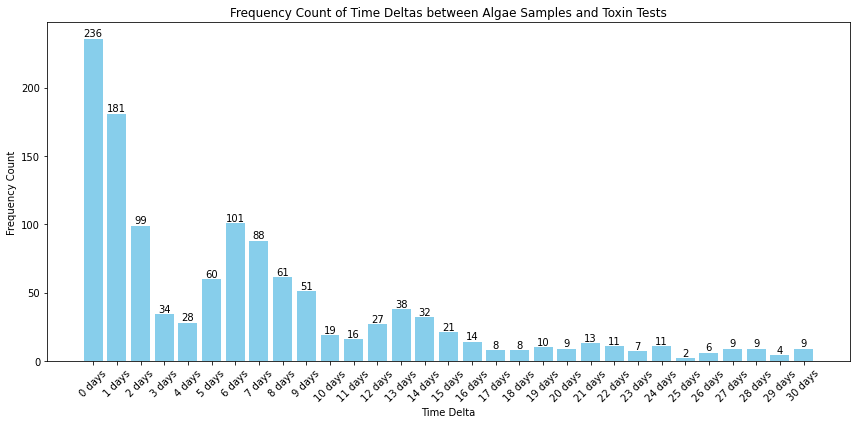

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that the 'lipophylic_toxins_timedelta' column is in the correct datatype for counting
df_cons["lipophylic_toxins_timedelta"] = pd.to_timedelta(df_cons["lipophylic_toxins_timedelta"])

# Count the occurrences of each time delta value
time_delta_counts = df_cons["lipophylic_toxins_timedelta"].value_counts().sort_index()

# Create a new dataframe from the counts
df_time_delta_counts = pd.DataFrame(time_delta_counts).reset_index()
df_time_delta_counts.columns = ['Time Delta', 'Count']

# Plot the data
plt.figure(figsize=(12, 6))
bars = plt.bar(df_time_delta_counts['Time Delta'].astype(str), df_time_delta_counts['Count'], color='skyblue')

# Add frequency counts on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.xlabel('Time Delta')
plt.ylabel('Frequency Count')
plt.title('Frequency Count of Time Deltas between Algae Samples and Toxin Tests')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an image
plt.savefig('time_delta_frequency.png')

# Show the plot
plt.show()



In [19]:
# Check for unique values and missing values in the final consolidated dataset.
df_cons.lipophylic_toxins.value_counts(dropna=False)

neg    996
NaN    320
poz    136
Name: lipophylic_toxins, dtype: int64

In [20]:
df_cons.isnull().sum()

date                       0
sampling station           0
sampling depth             0
sampling method            0
DSP                        1
DSP_like                  60
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
lipophylic_toxins        320
dtype: int64

## Prepare exports for modelling

In [21]:
# Change sampling station names
df_cons["sampling station"].replace("35", "Seca", inplace=True)
df_cons["sampling station"].replace("24", "Strunjan", inplace=True)
df_cons["sampling station"].replace("0DB2", "Debeli_rtic", inplace=True)

In [22]:
# Export csv
df_cons.to_csv(f"data/HAB_bio-tox_{nb_fname}.csv", sep=",", na_rep="?", index=False)

In [23]:
# Create pickle
df_cons.to_pickle(f"objects/df_cons_{nb_fname}")

# Adding environmental and chemical data

## Sun radiation dataset

In [24]:
# Global sun radiation in kWh/m2
df_sun_kWh = pd.read_excel("data/Soncno sevanje 2000-2016.xlsx", header=3)

## 3.2 ARSO dataset

In [25]:
df_arso = pd.read_csv("data/ARSO 1993-2022.txt") 
df_arso = df_arso.loc[:, " valid":].copy()
df_arso.rename(columns = {" valid":"date", "trajanje sonca [h]":"sun [h]"}, inplace = True)
df_arso["date"] = pd.to_datetime(df_arso["date"])
df_arso = df_arso.set_index("date")
df_arso = df_arso.sort_values('date')
df_arso

,povp. dnevna T [°C],povp. veter [m/s],povp. rel. vla. [%],povp. tlak [hPa],količina padavin [mm],sun [h]
date,,,,,,
1993-01-01,0.7,6.3,43,1026,0.0,6.6
1993-01-02,-3.4,6.6,46,1027,0.0,4.0
1993-01-03,-1.7,6.5,47,1025,0.0,1.6
1993-01-04,-1.0,3.6,46,1031,0.0,6.4
1993-01-05,-1.4,2.8,59,1036,0.0,7.2
...,...,...,...,...,...,...
2022-06-26,25.3,2.7,57,1015,0.0,14.3
2022-06-27,26.8,2.1,54,1014,0.0,13.6
2022-06-28,27.4,3.2,53,1013,0.0,8.0


### Adding ARSO data to dataset 

In [26]:
# Loop to add appropriate summed sun radiation period before timestamp of an algae sample in the consolidated dataset. (Add precipiation, air temp)
df_cons2 = df_cons.copy()
df_cons2[["sun [h]", "air temp", "wind strength", "precipitation"]] = np.nan

max_range = pd.Timedelta(20, unit="day")
min_range = pd.Timedelta(0, unit="day")

# Iterate over consolidated df and select a date of the algae sample
for id_alg, date_alg in df_cons["date"].iteritems():
    # Iterate over ARSO df and selecet and instances in period and sum radiation values
    sun_values = []
    air_temp_val = []
    wind_str_val = []
    precip_val = []
    for date_arso in df_arso.index:
        # ***dodaj pandas select date range namesto loopa
        # Calculate the timespan between algae sample and sun radiation
        timespan = date_alg - date_arso
        # If timespan within radiation period
        if min_range <= timespan <= max_range:
            # Append value to sun_values list
            sun_values.append(df_arso.loc[date_arso, "sun [h]"])
            air_temp_val.append(df_arso.loc[date_arso, "povp. dnevna T [°C]"])
            wind_str_val.append(df_arso.loc[date_arso, "povp. veter [m/s]"])
            precip_val.append(df_arso.loc[date_arso, "količina padavin [mm]"])
        # Add sum of rad values to df_cons once all period values are found
        
    
    df_cons2.loc[id_alg, "sun [h]"] = sum(sun_values)
    df_cons2.loc[id_alg, "air temp"] = np.mean(air_temp_val)
    df_cons2.loc[id_alg, "wind strength"] = np.mean(wind_str_val)
    df_cons2.loc[id_alg, "precipitation"] = sum(precip_val)

In [27]:
pd.set_option("display.max_rows", 30)
df_cons2.isnull().sum()

date                       0
sampling station           0
sampling depth             0
sampling method            0
DSP                        1
DSP_like                  60
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
lipophylic_toxins        320
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
dtype: int64

## 3.3 Chemical dataset

In [74]:
pd.set_option("display.max_rows", 30)

In [79]:
df_sea = pd.read_excel("data/Fi_Ke_1994-2021_checked.xlsx")
df_sea

,datetime,station_id,depth,Chl-a,salinity,T,SECCHI,NH4-N,NO2-N,NO3-N,PO4-P,SiO3-Si,Org-N,TOT-N,TOT-P,O2,O2_sat,pH
0,1994-01-17 01:00:00,000F,0,2.36,36.980000,10.62,6.5,1.51,1.390,3.15,0.03,2.43,33.220001,39.270000,0.66,304.130005,110.620003,8.13
1,1994-01-17 01:00:00,000K,0,1.63,36.910000,10.81,4.0,2.11,2.000,3.03,0.16,3.88,27.540001,34.680000,0.95,247.860001,90.489998,8.09
2,1994-01-17 01:00:00,00MA,0,1.50,36.780000,10.93,5.0,1.04,1.300,3.03,0.17,2.62,24.370001,29.740000,0.49,283.589996,103.709999,8.12
3,1994-01-17 01:00:00,000F,5,1.77,37.090000,10.62,NaN,1.23,1.380,2.50,0.19,2.34,34.090000,39.200001,0.60,284.040009,103.389999,8.10
4,1994-01-17 01:00:00,000K,5,1.28,37.590000,10.92,NaN,1.76,2.570,3.70,0.26,3.70,35.660000,43.689999,0.85,254.119995,93.389999,8.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351,2021-12-14 10:20:00,00BF,5,NaN,37.869999,12.22,NaN,0.03,1.532,1.24,0.04,1.84,NaN,NaN,NaN,351.140015,93.129997,8.19
3352,2021-12-14 12:45:00,000K,0,1.05,37.430000,12.27,5.0,0.42,1.080,4.89,0.09,5.17,NaN,NaN,NaN,352.309998,93.629997,8.13
3353,2021-12-14 12:45:00,000K,5,0.71,37.660000,12.10,NaN,0.03,1.117,1.91,0.05,2.70,NaN,NaN,NaN,352.700012,93.389999,8.15
3354,2021-12-14 13:25:00,0DB2,0,0.85,37.439999,11.68,5.0,0.03,1.173,1.95,0.03,2.58,NaN,NaN,NaN,359.329987,94.510002,8.22


In [81]:
df_sea["station_id"].value_counts()

000F    661
00BF    620
000K    606
00MA    606
0DB2    374
0024    269
0035    220
Name: station_id, dtype: int64

In [75]:
df_sea = pd.read_excel("data/Fi_Ke_1994-2021_checked.xlsx")
# For start choose 0 depth (but optimisation possible by keeping both depths as separate features!)
# df_sea = df_sea[(df_sea["depth"] == 0)]
df_sea.drop(["depth",  "Org-N", "TOT-N", "TOT-P", "O2_sat", "SiO3-Si", "O2", "pH",], axis=1, inplace=True)

df_sea["datetime"] = pd.to_datetime(df_sea["datetime"])
# df_sea = df_sea.set_index("datetime")
df_sea = df_sea.sort_values('datetime')

# Change sampling station names and combine close sampling stations
df_sea["station_id"].replace(["0035", "00MA"], "Seca", inplace=True)
df_sea["station_id"].replace(["0024", "000F", "00BF"], "Strunjan", inplace=True)
df_sea["station_id"].replace(["0DB2", "000K"], "Debeli_rtic", inplace=True)

df_sea["DIN"] = df_sea["NH4-N"] + df_sea["NO2-N"] + df_sea["NO3-N"]

df_sea = df_sea.drop(columns=["NH4-N", "NO2-N", "NO3-N"])

df_sea

,datetime,station_id,Chl-a,salinity,T,SECCHI,PO4-P,DIN
0,1994-01-17 01:00:00,Strunjan,2.36,36.980000,10.62,6.5,0.03,6.050
1,1994-01-17 01:00:00,Debeli_rtic,1.63,36.910000,10.81,4.0,0.16,7.140
2,1994-01-17 01:00:00,Seca,1.50,36.780000,10.93,5.0,0.17,5.370
3,1994-01-17 01:00:00,Strunjan,1.77,37.090000,10.62,NaN,0.19,5.110
4,1994-01-17 01:00:00,Debeli_rtic,1.28,37.590000,10.92,NaN,0.26,8.030
...,...,...,...,...,...,...,...,...
3351,2021-12-14 10:20:00,Strunjan,NaN,37.869999,12.22,NaN,0.04,2.802
3352,2021-12-14 12:45:00,Debeli_rtic,1.05,37.430000,12.27,5.0,0.09,6.390
3353,2021-12-14 12:45:00,Debeli_rtic,0.71,37.660000,12.10,NaN,0.05,3.057
3354,2021-12-14 13:25:00,Debeli_rtic,0.85,37.439999,11.68,5.0,0.03,3.153


In [78]:
df_sea["station_id"].value_counts()

Strunjan       1550
Debeli_rtic     980
Seca            826
Name: station_id, dtype: int64

In [30]:
# Check for missing values
# pd.set_option("display.max_rows", 20)
df_sea.isnull().sum()

datetime         0
station_id       0
Chl-a         1002
salinity        14
T              115
SECCHI        1916
PO4-P          534
DIN            553
dtype: int64

### Adding chemical data to dataset

If any of these data can be obtained on a daily basis it would provide more optimal values for the preiods of interest before the biological sampling.

In [31]:
# Add appropriate sea test before timestamp of an algae sample in the consolidated dataset 3. (option to avg values of several tests inside period)
df_cons3 = df_cons2.copy()
sea_test_cols = ['Chl-a', 'salinity', 'T', 'SECCHI', 'PO4-P', 'DIN']
df_cons3['Chl-a'], df_cons3['salinity'], df_cons3['T'], df_cons3['SECCHI'], df_cons3['DIN'], df_cons3['PO4-P'], = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

max_range = pd.Timedelta(30, unit="day")
min_range = pd.Timedelta(0, unit="day")

# Iterate over consolidated df 3 for each location seperately and select a suitable sea test (location, period).
# Iterate over the lovations of interest
for location in df_sea.station_id.unique():
    matches = 0
    for id_alg, date_alg in df_cons3.loc[df_cons3["sampling station"] == location, "date"].iteritems():
        # Iterate over ARSO df and selecet and instances in period and sum radiation values
        for id_sea, date_sea in df_sea.loc[df_sea["station_id"] == location, "datetime"].iteritems():
            # Calculate the timespan between algae sample and sea sample
            timespan = date_alg - date_sea
            #If timespan within relevant period
            if min_range <= timespan <= max_range:
                # Sea test on first acceptable sea test day (date_sea) 
                sea_test_val = df_sea.loc[id_sea, sea_test_cols]
                df_cons3.loc[id_alg, sea_test_cols] = sea_test_val
                matches += 1
                break
    print(f"Found matching test dates for {location}: {matches}")                    


Found matching test dates for Strunjan: 505
Found matching test dates for Debeli_rtic: 318
Found matching test dates for Seca: 442


In [32]:
df_cons3.isnull().sum()

date                       0
sampling station           0
sampling depth             0
sampling method            0
DSP                        1
DSP_like                  60
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
lipophylic_toxins        320
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    661
salinity                 191
T                        244
SECCHI                   696
DIN                      542
PO4-P                    534
dtype: int64

### 3.3.1 Sea temperature at 3m and seabed

In [33]:
# only from one location (buoy)!

In [34]:
df_sea_temp = pd.read_excel("data/Temp_sal_nov_2002_okt_2021.xlsx")

# df_sea_temp.drop(["depth",  "Org-N", "TOT-N", "TOT-P", "O2_sat", "SiO3-Si", "O2", "pH",], axis=1, inplace=True)

# create timestamp 
df_sea_temp["Datum"] = pd.to_datetime(df_sea_temp["Datum"])

df_sea_temp.rename(columns={"Datum" : "date"}, inplace=True)
df_sea_temp = df_sea_temp.sort_values('date')

df_sea_temp["temp_dif"] = df_sea_temp["Temperatura (3 m)"] - df_sea_temp["Temperatura (dno)"]

# df_sea_temp

In [35]:
# Loop to add appropriate summed sea temp difference before timestamp of an algae sample in the consolidated dataset.

df_cons3["temp_dif"] = np.nan

max_range = pd.Timedelta(20, unit="day")
min_range = pd.Timedelta(0, unit="day")

# Iterate over consolidated df and select a date of the algae sample
for id_alg, date_alg in df_cons3["date"].iteritems():
    # Iterate over df_sea_temp and select instances in period and sum values
    temp_val = []
    for id_temp, date_temp in df_sea_temp["date"].iteritems():
        # Calculate the timespan between algae sample and river flow meassurement
        timespan = date_alg - date_temp
        # If timespan within period
        if min_range <= timespan <= max_range:
            # Append value to sun_values list
            temp_val.append(df_sea_temp.loc[id_temp, "temp_dif"])
        # Add sum of temp values to df_cons once all period values are found

    df_cons3.loc[id_alg, "temp_dif"] = sum(temp_val)

## 3.4 River inflow dataset

In [36]:
import openpyxl

# Create Soca dataframe
df_river = pd.read_excel("data/Pretok_Soča_dnevni_1994-2021.xlsx", usecols=["Datum", "SOCA (m3/s)"])  
df_river["Datum"] = pd.to_datetime(df_river["Datum"], dayfirst=True)
# # df_soca = df_soca.set_index("Year_month")
df_river = df_river.sort_values('Datum')
# df_soca = df_soca.to_period()
# df_soca["Day_of_the_Year"] = df_soca["Year_month"].dt.dayofyear

df_river

,Datum,SOCA (m3/s)
0,1994-01-01 00:00:00,253.608
1,1994-01-02 00:00:00,292.310
2,1994-01-03 00:00:00,167.759
3,1994-01-04 00:00:00,187.153
4,1994-01-05 00:00:00,709.643
...,...,...
10246,2021-12-27 12:00:00,99.788
10247,2021-12-28 12:00:00,80.257
10248,2021-12-29 12:00:00,80.442
10249,2021-12-30 12:00:00,66.033


### Adding river inflow data

In [37]:
# Loop to add appropriate summed river inflow before timestamp of an algae sample in the consolidated dataset.
df_cons4 = df_cons3.copy()
df_cons4["Soca"] = np.nan

max_range = pd.Timedelta(30, unit="day")
min_range = pd.Timedelta(0, unit="day")

# Iterate over consolidated df and select a date of the algae sample
for id_alg, date_alg in df_cons4["date"].iteritems():
    # Iterate over ARSO df and selecet and instances in period and sum values
    river_val = []
    for id_river, date_river in df_river["Datum"].iteritems():
        # Calculate the timespan between algae sample and river flow meassurement
        timespan = date_alg - date_river
        # If timespan within period
        if min_range <= timespan <= max_range:
            # Append value to river_values list
            river_val.append(df_river.loc[id_river, "SOCA (m3/s)"])
        # Add sum of river flow values to df_cons once all period values are found

    df_cons4.loc[id_alg, "Soca"] = sum(river_val)

In [38]:
# Change date to month only
df_cons4["month"] = df_cons4["date"].dt.month

# Move target feature to the end
pd.set_option("display.max_rows", 20)
df_temp = df_cons4.pop("lipophylic_toxins")
df_cons4["lipophylic_toxins"] = df_temp

#drop irrelevant featutres
df_cons4 = df_cons4.drop(columns=["sampling depth", "sampling method"])
df_cons4

,date,sampling station,DSP,DSP_like,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,sun [h],air temp,wind strength,precipitation,Chl-a,salinity,T,SECCHI,DIN,PO4-P,temp_dif,Soca,month,lipophylic_toxins
0,1994-05-17,Seca,68.0,NaN,27.0,0.0,21.0,0.0,0.0,197.1,15.114286,2.933333,26.2,1.15,33.780000,13.580000,7.0,8.040,0.15,0.0,3030.486,5,NaN
3,1994-05-17,Strunjan,17.0,NaN,8.0,0.0,0.0,0.0,0.0,197.1,15.114286,2.933333,26.2,0.45,36.180000,12.620000,8.0,1.760,0.12,0.0,3030.486,5,NaN
6,1994-06-06,Debeli_rtic,27.0,NaN,16.0,3.0,5.0,0.0,0.0,166.3,18.790476,3.157143,18.8,1.11,35.530000,17.030000,NaN,2.620,0.22,0.0,3931.331,6,NaN
7,1994-06-13,Strunjan,23.0,NaN,3.0,0.0,0.0,0.0,0.0,179.1,18.533333,3.052381,23.9,1.05,35.010000,19.890000,NaN,3.920,0.09,0.0,4090.322,6,NaN
8,1994-06-21,Seca,20.0,NaN,8.0,0.0,0.0,0.0,0.0,157.5,19.095238,3.066667,29.8,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3221.804,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,2021-11-30,Seca,140.0,0.0,10.0,60.0,40.0,0.0,0.0,66.8,9.823810,2.738095,49.4,0.58,37.880001,15.500000,5.0,1.372,0.01,0.0,3392.723,11,poz
1648,2021-11-30,Debeli_rtic,50.0,10.0,0.0,30.0,20.0,0.0,0.0,66.8,9.823810,2.738095,49.4,0.69,37.860001,15.150000,NaN,1.145,0.01,0.0,3392.723,11,poz
1650,2021-12-14,Seca,10.0,0.0,0.0,0.0,10.0,0.0,0.0,64.4,6.371429,2.980952,114.4,0.58,37.880001,15.500000,5.0,1.372,0.01,0.0,3357.036,12,neg
1649,2021-12-14,Strunjan,60.0,0.0,0.0,20.0,30.0,0.0,0.0,64.4,6.371429,2.980952,114.4,0.46,37.930000,16.030001,6.0,1.204,0.01,0.0,3357.036,12,neg


In [39]:
pd.set_option('display.max_rows', 30)
df_cons4.isnull().sum()

date                       0
sampling station           0
DSP                        1
DSP_like                  60
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    661
salinity                 191
T                        244
SECCHI                   696
DIN                      542
PO4-P                    534
temp_dif                 346
Soca                       0
month                      0
lipophylic_toxins        320
dtype: int64

In [40]:
df_cons4["lipophylic_toxins"].value_counts(dropna=False)

neg    996
NaN    320
poz    136
Name: lipophylic_toxins, dtype: int64

In [41]:
# Create pickle
df_cons4.to_pickle(f"objects/df_cons4-{nb_fname}")

In [42]:
# Export csv
df_cons4.to_csv(f"data/cons4_{nb_fname}.csv", sep=",", na_rep="?", index=False)

In [58]:
# # C5 export function 
# def C5_export(df, file_prefix, target, max_values=10):
#     with open(file_prefix + ".names", "w") as fp:
#         print("{}.\n".format(target), file=fp)
#         columns = df.columns
#         for col in columns:
#             values = [str(x) for x in set(df[col].value_counts().index) if x !="?"]
#             if len(values) > max_values:
#                 print("{}: continuous.".format(col), file=fp)
#             else:
#                 print("{}: {}.".format(col, ",".join(values)), file=fp)
#     df.to_csv(file_prefix + ".data", header=False, na_rep="?", index=False)

# target = "lipophylic_toxins"
# C5_export(df_cons4, nb_fname, target, max_values=12)

## Preview of data (missing by station, time)

In [44]:
df_cons4.set_index('date', inplace=True)

In [45]:
df_cons4.loc["2013-01-01" : "2021-12-31"].isnull().sum()

sampling station           0
DSP                        1
DSP_like                   1
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    300
salinity                 100
T                        100
SECCHI                   198
DIN                      223
PO4-P                    215
temp_dif                 177
Soca                       0
month                      0
lipophylic_toxins         63
dtype: int64

In [46]:
df_cons4.loc["2013-01-01" : "2021-12-31"]["lipophylic_toxins"].value_counts(dropna=False)

neg    526
NaN     63
poz     32
Name: lipophylic_toxins, dtype: int64

### Debeli_rtic

In [47]:
df_cons4.loc[df_cons4["sampling station"] == "Debeli_rtic"].isnull().sum()

sampling station           0
DSP                        0
DSP_like                   5
Dinophysis caudata         0
Dinophysis fortii          0
Phalacroma rotundatum      0
Dinophysis sacculus        0
Dinophysis tripos          0
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    101
salinity                  72
T                         72
SECCHI                   194
DIN                      114
PO4-P                    114
temp_dif                 114
Soca                       0
month                      0
lipophylic_toxins         84
dtype: int64

In [48]:
df_cons4.loc[df_cons4["sampling station"] == "Debeli_rtic"]["lipophylic_toxins"].value_counts(dropna=False)

neg    273
NaN     84
poz     33
Name: lipophylic_toxins, dtype: int64

### Seca

In [49]:
df_cons4.loc[df_cons4["sampling station"] == "Seca"].isnull().sum()

sampling station           0
DSP                        1
DSP_like                  28
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    317
salinity                  90
T                         93
SECCHI                   256
DIN                      322
PO4-P                    322
temp_dif                 120
Soca                       0
month                      0
lipophylic_toxins        116
dtype: int64

In [50]:
df_cons4.loc[df_cons4["sampling station"] == "Seca"]["lipophylic_toxins"].value_counts(dropna=False)

neg    365
NaN    116
poz     51
Name: lipophylic_toxins, dtype: int64

### Strunjan

In [51]:
df_cons4.loc[df_cons4["sampling station"] == "Strunjan"].isnull().sum()

sampling station           0
DSP                        0
DSP_like                  27
Dinophysis caudata         0
Dinophysis fortii          0
Phalacroma rotundatum      0
Dinophysis sacculus        0
Dinophysis tripos          0
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    243
salinity                  29
T                         79
SECCHI                   246
DIN                      106
PO4-P                     98
temp_dif                 112
Soca                       0
month                      0
lipophylic_toxins        120
dtype: int64

In [52]:
df_cons4.loc[df_cons4["sampling station"] == "Strunjan"]["lipophylic_toxins"].value_counts(dropna=False)

neg    358
NaN    120
poz     52
Name: lipophylic_toxins, dtype: int64

### Intersection (slice by time and sampling station)

In [53]:
df_cons4[df_cons4["sampling station"] == "Strunjan"].loc["2008-01-01" : "2021-12-31"].isnull().sum()

sampling station           0
DSP                        0
DSP_like                   0
Dinophysis caudata         0
Dinophysis fortii          0
Phalacroma rotundatum      0
Dinophysis sacculus        0
Dinophysis tripos          0
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    199
salinity                  14
T                         28
SECCHI                   105
DIN                       48
PO4-P                     40
temp_dif                  89
Soca                       0
month                      0
lipophylic_toxins         41
dtype: int64

In [54]:
df_cons4[df_cons4["sampling station"] == "Strunjan"].loc["2008-01-01" : "2021-12-31"]["lipophylic_toxins"].value_counts(dropna=False)

neg    253
NaN     41
poz     36
Name: lipophylic_toxins, dtype: int64

In [55]:
df_cons4[df_cons4["sampling station"] == "Debeli_rtic"].loc["2008-01-01" : "2021-12-31"].isnull().sum()

sampling station           0
DSP                        0
DSP_like                   0
Dinophysis caudata         0
Dinophysis fortii          0
Phalacroma rotundatum      0
Dinophysis sacculus        0
Dinophysis tripos          0
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                     67
salinity                  67
T                         67
SECCHI                   165
DIN                       80
PO4-P                     80
temp_dif                  90
Soca                       0
month                      0
lipophylic_toxins         57
dtype: int64

In [56]:
df_cons4[df_cons4["sampling station"] == "Debeli_rtic"].loc["2008-01-01" : "2021-12-31"]["lipophylic_toxins"].value_counts(dropna=False)

neg    242
NaN     57
poz     31
Name: lipophylic_toxins, dtype: int64

In [57]:
pd.set_option("display.max_rows", 3)
pd.set_option("display.max_columns", 30)
df_cons4

,sampling station,DSP,DSP_like,Dinophysis caudata,Dinophysis fortii,Phalacroma rotundatum,Dinophysis sacculus,Dinophysis tripos,sun [h],air temp,wind strength,precipitation,Chl-a,salinity,T,SECCHI,DIN,PO4-P,temp_dif,Soca,month,lipophylic_toxins
date,,,,,,,,,,,,,,,,,,,,,,
1994-05-17,Seca,68.0,NaN,27.0,0.0,21.0,0.0,0.0,197.1,15.114286,2.933333,26.2,1.15,33.780000,13.58,7.0,8.040,0.15,0.0,3030.486,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14,Debeli_rtic,30.0,0.0,0.0,20.0,10.0,0.0,0.0,64.4,6.371429,2.980952,114.4,0.69,37.860001,15.15,NaN,1.145,0.01,0.0,3357.036,12,neg
